In [1]:
# labeledDataToblockData
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft

In [9]:
#验证 数据块分类是否正确代码
blocked_data = pd.read_csv("../DATA/tactile_dataset_block.csv")
blocked_data
# blocked_data.sort_values(by='block_id',ascending=True)
st_data_block = blocked_data[blocked_data['touch_type'] == 'NC']
st_data_block
# st_data_block[st_data_block['block_id']==54]


# contacted_data = pd.read_csv("DATA/tactile_dataset_contact_NC.csv")
# contacted_data
# contacted_data['contact_id'].nunique()
# st_data_contact = contacted_data[contacted_data['touch_type'] == 'DT' ]
# st_data_contact[st_data_contact['contact_id']==243]

# labeled_data.columns.tolist()
# # label_0_data = labeled_data[labeled_data['label'] == 1]
# # print(label_0_data.head())

# 只筛选出 touch_type 为 'ST' 的数据
# st_data = labeled_data[labeled_data['touch_type'] == 'DT' ]
# st_data[st_data['block_id']==0]

,index,time,tau_J0,tau_J1,tau_J2,tau_J3,tau_J4,tau_J5,tau_J6,tau_J_d0,...,etau_J0,etau_J1,etau_J2,etau_J3,etau_J4,etau_J5,etau_J6,label,block_id,touch_type
102200,1,178307.941782,-0.113244,-14.130056,1.881520,20.692209,0.474571,2.341808,-0.059643,0.0,...,0.113244,14.130056,-1.881520,-20.692209,-0.474571,-2.341808,0.059643,0,511,NC
102201,2,178307.946779,-0.073572,-14.130056,1.952932,20.727915,0.437950,2.352795,-0.059643,0.0,...,0.073572,14.130056,-1.952932,-20.727915,-0.437950,-2.352795,0.059643,0,511,NC
102202,3,178307.951778,-0.113244,-14.130056,1.881520,20.692209,0.474571,2.341808,-0.059643,0.0,...,0.113244,14.130056,-1.881520,-20.692209,-0.474571,-2.341808,0.059643,0,511,NC
102203,4,178307.956779,-0.073572,-14.130056,1.952932,20.727915,0.437950,2.352795,-0.059643,0.0,...,0.073572,14.130056,-1.952932,-20.727915,-0.437950,-2.352795,0.059643,0,511,NC
102204,5,178307.961779,-0.113244,-14.130056,1.881520,20.692209,0.474571,2.341808,-0.059643,0.0,...,0.113244,14.130056,-1.881520,-20.692209,-0.474571,-2.341808,0.059643,0,511,NC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160998,58799,178601.931779,-0.002160,-14.130056,1.917226,20.727915,0.465415,2.383923,-0.028515,0.0,...,0.002160,14.130056,-1.917226,-20.727915,-0.465415,-2.383923,0.028515,0,804,NC
160999,58800,178601.936778,-0.113244,-14.130056,1.881520,20.767588,0.456260,2.341808,0.001698,0.0,...,0.113244,14.130056,-1.881520,-20.767588,-0.456260,-2.341808,-0.001698,0,804,NC
161000,58801,178601.941775,-0.002160,-14.130056,1.917226,20.727915,0.465415,2.383923,-0.028515,0.0,...,0.002160,14.130056,-1.917226,-20.727915,-0.465415,-2.383923,0.028515,0,805,NC
161001,58802,178601.946772,-0.037866,-14.090384,1.917226,20.727915,0.474571,2.373852,-0.069713,0.0,...,0.037866,14.090384,-1.917226,-20.727915,-0.474571,-2.373852,0.069713,0,805,NC


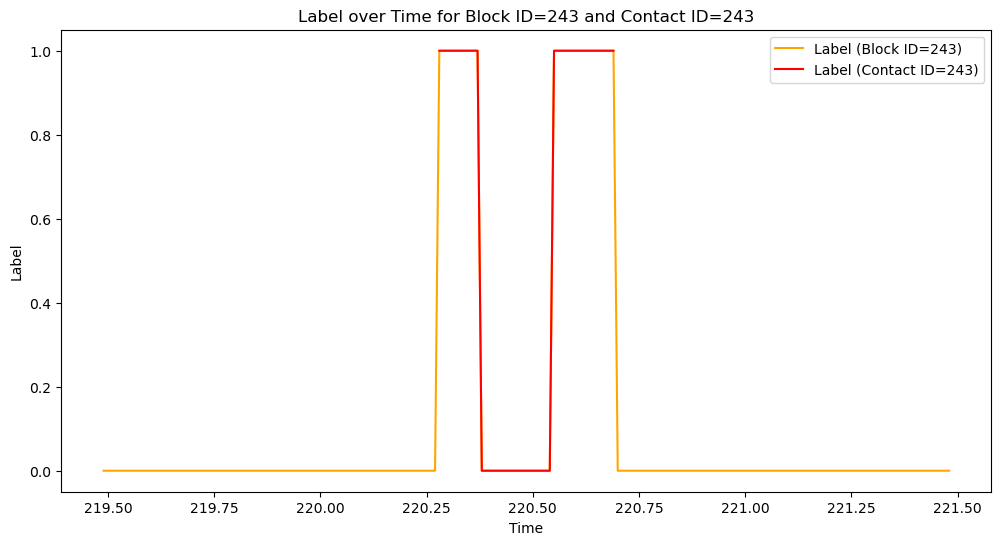

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
contact_data = pd.read_csv('../DATA/tactile_dataset_contact.csv')
block_data = pd.read_csv('../DATA/tactile_dataset_block.csv')

# Filter data for block_id=1 and contact_id=1
block_data_filtered = block_data[block_data['block_id'] == 54]
contact_data_filtered = contact_data[contact_data['contact_id'] == 54]

# Create a figure
plt.figure(figsize=(12, 6))

# Plot label from block_data (block_id=1) over time
plt.plot(block_data_filtered['time'], block_data_filtered['label'], label='Label (Block ID=243)', color='orange')

# Plot label from contact_data (contact_id=1) over time
plt.plot(contact_data_filtered['time'], contact_data_filtered['label'], label='Label (Contact ID=243)', color='red')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Label')
plt.title('Label over Time for Block ID=243 and Contact ID=243')

# Add legend
plt.legend()

# Show plot
plt.show()



In [7]:
#切割数据，每个打上对应的tactile,包括NC数据
import os
import pandas as pd

global_contact_id = 0
global_block_id = 0

def process_labeledDta(file_path, tactile_type, block_len):
    """处理单个labeled_data.csv文件，将连续label为1的数据块标记为指定触碰类型"""
    global global_contact_id, global_block_id
    df = pd.read_csv(file_path)
    labeled_contacts = []
    labeled_blocks = []

    in_contact = False
    contact_start = 0
    contact_end = 0
    block_start = 0
    block_end = 0
    
    contact_info = []
    block_info = []

    for i in range(len(df)):
        if df.iloc[i, df.columns.get_loc('label')] == 1 and not in_contact:
            in_contact = True
            contact_start = i
        elif df.iloc[i, df.columns.get_loc('label')] == 0 and in_contact:
            in_contact = False
            contact_end = i - 1
            # 用于规范块的长度
            contact_len = contact_end - contact_start + 1
            len_diff = block_len - contact_len
            block_start = contact_start - int(len_diff/2)  # 避免长度差异是奇数
            block_end = block_start + block_len - 1

            contact = df.iloc[contact_start:contact_end + 1].copy() # iloc 是 [) 所以 + 1
            contact['touch_type'] = tactile_type
            contact['contact_id'] = global_contact_id  # 添加全局唯一数据块标识符
            labeled_contacts.append(contact)
            contact_info.append((global_contact_id, contact_start, contact_end))  # 记录块的ID、开始行和结束行
            global_contact_id += 1  # 增加全局唯一数据块标识符
            
            block = df.iloc[block_start:block_end + 1].copy() # iloc 是 [) 所以 + 1
            block['touch_type'] = tactile_type
            block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
            labeled_blocks.append(block)
            block_info.append((global_block_id, block_start, block_end))  # 记录块的ID、开始行和结束行
            global_block_id += 1  # 增加全局唯一数据块标识符
    
    return labeled_contacts, contact_info, labeled_blocks, block_info

def process_nc_data(file_path, tactile_type, block_len):
    """处理没有触碰的数据，将数据按block_len切块并标记为NC"""
    global global_block_id
    df = pd.read_csv(file_path)
    labeled_blocks = []
    
    print(f"Processing NC data from {file_path}")

    for start_idx in range(0, len(df), block_len):
        end_idx = min(start_idx + block_len, len(df))
        block = df.iloc[start_idx:end_idx].copy()
        block['touch_type'] = tactile_type
        block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
        labeled_blocks.append(block)
        global_block_id += 1  # 增加全局唯一数据块标识符
    
    print(f"Generated {len(labeled_blocks)} blocks for NC data")

    return labeled_blocks

def calculate_zero_counts(df, contact_info):
    """计算相邻数据块之间0的个数"""
    zero_counts = []
    for i in range(len(contact_info) - 1):
        end_of_current_contact = contact_info[i][2]
        start_of_next_contact = contact_info[i + 1][1]
        zero_count = (df.iloc[end_of_current_contact + 1:start_of_next_contact]['label'] == 0).sum()
        zero_counts.append((contact_info[i][0], contact_info[i + 1][0], zero_count))
    return zero_counts

def determine_double_taps(zero_counts):
    """根据0的个数决定哪些单拍应该合并为双拍"""
    zero_counts_values = [count[2] for count in zero_counts]
    zero_counts_values.sort()
    n = len(zero_counts_values)
    max_value_index = int((n / 2) / (n + 1) * n)
    max_value = zero_counts_values[max_value_index]
    min_value = zero_counts_values[0]
    
    double_tap_contacts = []
    for start_contact_id, end_contact_id, zero_count in zero_counts:
        if min_value <= zero_count <= max_value:
            double_tap_contacts.append((start_contact_id, end_contact_id))
    return double_tap_contacts

def merge_continuous_double_taps(double_tap_contacts):
    """合并连续的双拍块对"""
    merged_double_tap_contacts = []

    current_start = None
    current_end = None
    
    for start_contact_id, end_contact_id in double_tap_contacts:
        if current_start is None:
            current_start = start_contact_id
            current_end = end_contact_id
        elif start_contact_id == current_end:
            current_end = end_contact_id
            current_start = start_contact_id
            current_end = end_contact_id
        elif start_contact_id == current_end:
            current_end = end_contact_id
        else:
            merged_double_tap_contacts.append((current_start, current_end))
            current_start = start_contact_id
            current_end = end_contact_id
    
    if current_start is not None:
        merged_double_tap_contacts.append((current_start, current_end))
    
    return merged_double_tap_contacts

def merge_double_taps(df, contact_info, double_tap_contacts, start_contact_id, start_block_id, block_len):
    """合并确定的双拍数据块"""
    merged_double_tap_contacts = merge_continuous_double_taps(double_tap_contacts)
    merged_contacts = []
    merged_blocks = []
    new_contact_id = start_contact_id
    new_block_id = start_block_id
 
    for start_contact_id, end_contact_id in merged_double_tap_contacts:
        start_row = next(bi[1] for bi in contact_info if bi[0] == start_contact_id)
        end_row = next(bi[2] for bi in contact_info if bi[0] == end_contact_id)
       
        # 用于规范块的长度
        contact_len = end_row - start_row
        len_diff = block_len - contact_len
        block_start = start_row - int(len_diff/2)  # 避免长度差异是奇数
        block_end = block_start + block_len -1  # 还需要处理块的开始和结束
 
        merged_contact = df.iloc[start_row:end_row + 1].copy() # iloc 是 [) 所以 + 1
        merged_contact['contact_id'] = new_contact_id  # 使用新的连续编号
        merged_contact['touch_type'] = 'DT'  # 标记为双拍
       
        merged_contacts.append(merged_contact)
        new_contact_id += 1
 
        merged_block = df.iloc[block_start:block_end + 1].copy() # iloc 是 [) 所以 + 1
        merged_block['block_id'] = new_block_id  # 使用新的连续编号
        merged_block['touch_type'] = 'DT'  # 标记为双拍
       
        merged_blocks.append(merged_block)
        new_block_id += 1
 
    return merged_contacts, new_contact_id, merged_blocks, new_block_id

def process_double_tap_folder(df, file_path, tactile_type, start_contact_id, start_block_id, block_len):
    """处理双拍数据，将挨得非常近的两个连续块标记为双拍类型"""
    labeled_contacts, contact_info, labeled_blocks, block_info = process_labeledDta(file_path, tactile_type, block_len)
    zero_counts = calculate_zero_counts(df, contact_info)
    double_tap_contacts = determine_double_taps(zero_counts)
    merged_contacts, new_contact_id, merged_blocks, new_block_id = merge_double_taps(df, contact_info, double_tap_contacts, start_contact_id, start_block_id, block_len)
    return merged_contacts, new_contact_id, merged_blocks, new_block_id
 
def process_single_folder(data_folder, folder_name, start_contact_id, start_block_id, block_len):
    """处理指定文件夹下的labeled_data.csv，统计数据块个数，并打印块的开始行和结束行"""
    folder_path = os.path.join(data_folder, folder_name)
   
    if os.path.isdir(folder_path):  # 检查是否为目录
        file_path = os.path.join(folder_path, 'labeled_data.csv')
       
        if os.path.isfile(file_path):
            tactile_type = folder_name.split('-')[1][1:]
            df = pd.read_csv(file_path)

            print(f"Processing folder {folder_name} with tactile_type {tactile_type}")  # 调试输出
           
            if tactile_type == 'DT':
                contacts, new_contact_id, blocks, new_block_id = process_double_tap_folder(df, file_path, tactile_type, start_contact_id, start_block_id, block_len)
            elif tactile_type in ['ST', 'G', 'P']:
                contacts, _, blocks, _ = process_labeledDta(file_path, tactile_type, block_len)
                new_contact_id = start_contact_id + len(contacts)
                new_block_id = start_block_id + len(blocks)
            elif tactile_type == 'NC':
                contacts = []  # No contacts since NC means no touch
                blocks = process_nc_data(file_path, tactile_type, block_len)
                new_contact_id = start_contact_id
                new_block_id = start_block_id + len(blocks)
            else:
                contacts = []
                new_contact_id = start_contact_id
                blocks = []
                new_block_id = start_block_id


            print(f"Finished processing {folder_name}, generated {len(blocks)} blocks")
            
            return contacts, new_contact_id, blocks, new_block_id
        else:
            print(f"文件夹 {folder_name} 下没有找到labeled_data.csv文件")
            return [], start_contact_id, [], start_block_id
    else:
        print(f"{folder_name} 不是有效的文件夹")
        return [], start_contact_id, [], start_block_id
 
def process_all_folders(data_folder, output_file, block_len):
    """处理所有子文件夹，合并所有数据块，生成tactile_dataset_contact.csv文件和tactile_dataset_block.csv文件"""
    all_contacts = []
    all_blocks = []
    global global_contact_id, global_block_id
    global_contact_id = 0 # 在开始时重置 global_contact_id
    global_block_id = 0  # 在开始时重置 global_block_id
   
    for folder_name in os.listdir(data_folder):
        # folder_path = os.path.join(data_folder, folder_name)
        
        # 忽略 .DS_Store 文件和其他非目录
        if folder_name == '.DS_Store':
            continue


        # print(os.listdir(data_folder))


        folder_contacts, global_contact_id, folder_blocks, global_block_id = process_single_folder(data_folder, folder_name, global_contact_id, global_block_id, block_len)
        
        
        all_contacts.extend(folder_contacts)
        all_blocks.extend(folder_blocks)
   
    if all_contacts:
        result_df_contact = pd.concat(all_contacts, ignore_index=True)
        output_path_contact = os.path.join(output_file, 'tactile_dataset_contact.csv')
    if all_blocks:
        result_df_block = pd.concat(all_blocks, ignore_index=True)
        output_path_block = os.path.join(output_file, 'tactile_dataset_block.csv')
       
        # 删除已存在的文件
        if os.path.exists(output_path_contact):
            os.remove(output_path_contact)
        if os.path.exists(output_path_block):
            os.remove(output_path_block)
       
        # 保存新文件
        result_df_contact.to_csv(output_path_contact, index=False)
        print(f"tactile_dataset_contact.csv 文件已生成，包含 {len(all_contacts)} 个数据块")
        result_df_block.to_csv(output_path_block, index=False)
        print(f"tactile_dataset_block.csv 文件已生成，包含 {len(all_blocks)} 个数据块")
    else:
        print("没有数据块被处理")
 
# 设置数据文件夹路径
# data_folder = '/Users/shangyu/Documents/GitHub/tactileGestureDetection/DATA/Labeled_data'
# output_file = '/Users/shangyu/Documents/GitHub/tactileGestureDetection/DATA/'
data_folder = '../DATA/Labeled_data'
output_file = '../DATA/'
block_len = 200
process_all_folders(data_folder, output_file, block_len)

Processing folder 0724-7DT-S1 with tactile_type DT
Finished processing 0724-7DT-S1, generated 59 blocks
Processing folder 0724-7DT-Y1 with tactile_type DT
Finished processing 0724-7DT-Y1, generated 60 blocks
Processing folder 0724-7G-S1 with tactile_type G
Finished processing 0724-7G-S1, generated 66 blocks
Processing folder 0724-7G-Y1 with tactile_type G
Finished processing 0724-7G-Y1, generated 63 blocks
Processing folder 0724-7P-S1 with tactile_type P
Finished processing 0724-7P-S1, generated 66 blocks
Processing folder 0724-7P-Y1 with tactile_type P
Finished processing 0724-7P-Y1, generated 72 blocks
Processing folder 0724-7ST-S1 with tactile_type ST
Finished processing 0724-7ST-S1, generated 63 blocks
Processing folder 0724-7ST-Y1 with tactile_type ST
Finished processing 0724-7ST-Y1, generated 62 blocks
Processing folder 0820-0NC-Y with tactile_type NC
Processing NC data from ../DATA/Labeled_data\0820-0NC-Y\labeled_data.csv
Generated 295 blocks for NC data
Finished processing 0820

In [ ]:
#切割数据，每个打上对应的tactile 
import os
import pandas as pd

global_contact_id = 0
global_block_id = 0

def process_labeledDta(file_path, tactile_type, block_len):
    """处理单个labeled_data.csv文件，将连续label为1的数据块标记为指定触碰类型"""
    global global_contact_id, global_block_id
    df = pd.read_csv(file_path)
    labeled_contacts = []
    labeled_blocks = []

    in_contact = False
    contact_start = 0
    contact_end = 0
    block_start = 0
    block_end = 0
    
    contact_info = []
    block_info = []

    for i in range(len(df)):
        if df.iloc[i, df.columns.get_loc('label')] == 1 and not in_contact:
            in_contact = True
            contact_start = i
        elif df.iloc[i, df.columns.get_loc('label')] == 0 and in_contact:
            in_contact = False
            contact_end = i - 1
            # Used to regulize block to same length 
            contact_len = contact_end - contact_start + 1
            len_diff = block_len - contact_len
            block_start = contact_start - int(len_diff/2)  # avoid length diffrence is odd
            block_end = block_start + block_len - 1

            contact = df.iloc[contact_start:contact_end + 1].copy() # iloc is [) so + 1
            contact['touch_type'] = tactile_type
            contact['contact_id'] = global_contact_id  # 添加全局唯一数据块标识符
            labeled_contacts.append(contact)
            contact_info.append((global_contact_id, contact_start, contact_end))  # 记录块的ID、开始行和结束行
            global_contact_id += 1  # 增加全局唯一数据块标识符
            
            
            block = df.iloc[block_start:block_end + 1].copy() # iloc is [) so + 1
            block['touch_type'] = tactile_type
            block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
            labeled_blocks.append(block)
            block_info.append((global_block_id, block_start, block_end))  # 记录块的ID、开始行和结束行
            global_block_id += 1  # 增加全局唯一数据块标识符

    # # To dealing with 0111111 at the end of the data file(but already avoided during data collecting phase)
    # if in_block:
    #     block = df.iloc[block_start:].copy()
    #     block['touch_type'] = tactile_type
    #     block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
    #     labeled_blocks.append(block)
    #     block_info.append((global_block_id, block_start, len(df) - 1))  # 记录块的ID、开始行和结束行
    #     global_block_id += 1  # 增加全局唯一数据块标识符
    
    return labeled_contacts, contact_info, labeled_blocks, block_info

def calculate_zero_counts(df, contact_info):
    """计算相邻数据块之间0的个数"""
    zero_counts = []
    for i in range(len(contact_info) - 1):
        end_of_current_contact = contact_info[i][2]
        start_of_next_contact = contact_info[i + 1][1]
        zero_count = (df.iloc[end_of_current_contact + 1:start_of_next_contact]['label'] == 0).sum()
        zero_counts.append((contact_info[i][0], contact_info[i + 1][0], zero_count))
    return zero_counts

def determine_double_taps(zero_counts):
    """根据0的个数决定哪些单拍应该合并为双拍"""
    zero_counts_values = [count[2] for count in zero_counts]
    zero_counts_values.sort()
    n = len(zero_counts_values)
    max_value_index = int((n / 2) / (n + 1) * n)
    max_value = zero_counts_values[max_value_index]
    min_value = zero_counts_values[0]
    
    double_tap_contacts = []
    for start_contact_id, end_contact_id, zero_count in zero_counts:
        if min_value <= zero_count <= max_value:
            double_tap_contacts.append((start_contact_id, end_contact_id))
    return double_tap_contacts

def merge_continuous_double_taps(double_tap_contacts):
    """合并连续的双拍块对"""
    merged_double_tap_contacts = []

    current_start = None
    current_end = None
    
    for start_contact_id, end_contact_id in double_tap_contacts:
        if current_start is None:
            current_start = start_contact_id
            current_end = end_contact_id
        elif start_contact_id == current_end:
            current_end = end_contact_id
            current_start = start_contact_id
            current_end = end_contact_id
        elif start_contact_id == current_end:
            current_end = end_contact_id
        else:
            merged_double_tap_contacts.append((current_start, current_end))
            current_start = start_contact_id
            current_end = end_contact_id
    
    if current_start is not None:
        merged_double_tap_contacts.append((current_start, current_end))
    
    return merged_double_tap_contacts

def merge_double_taps(df, contact_info, double_tap_contacts, start_contact_id, start_block_id, block_len):
    """合并确定的双拍数据块"""
    merged_double_tap_contacts = merge_continuous_double_taps(double_tap_contacts)
    merged_contacts = []
    merged_blocks = []
    new_contact_id = start_contact_id
    new_block_id = start_block_id
 
    for start_contact_id, end_contact_id in merged_double_tap_contacts:
        start_row = next(bi[1] for bi in contact_info if bi[0] == start_contact_id)
        end_row = next(bi[2] for bi in contact_info if bi[0] == end_contact_id)
       
        # Used to regulize block to same length
        contact_len = end_row - start_row
        len_diff = block_len - contact_len
        block_start = start_row - int(len_diff/2)  # avoid length diffrence is odd
        block_end = block_start + block_len -1  # still need to deal with the beginning and ending
 
        merged_contact = df.iloc[start_row:end_row + 1].copy() # iloc is [) so + 1
        merged_contact['contact_id'] = new_contact_id  # 使用新的连续编号
        merged_contact['touch_type'] = 'DT'  # 标记为双拍
       
        merged_contacts.append(merged_contact)
        new_contact_id += 1
 
        merged_block = df.iloc[block_start:block_end + 1].copy() # iloc is [) so + 1
        merged_block['block_id'] = new_block_id  # 使用新的连续编号
        merged_block['touch_type'] = 'DT'  # 标记为双拍
       
        merged_blocks.append(merged_block)
        new_block_id += 1
 
    return merged_contacts, new_contact_id, merged_blocks, new_block_id

def process_double_tap_folder(df, file_path, tactile_type, start_contact_id, start_block_id, block_len):
    """处理双拍数据，将挨得非常近的两个连续块标记为双拍类型"""
    labeled_contacts, contact_info, labeled_blocks, block_info = process_labeledDta(file_path, tactile_type, block_len)
    zero_counts = calculate_zero_counts(df, contact_info)
    double_tap_contacts = determine_double_taps(zero_counts)
    merged_contacts, new_contact_id, merged_blocks, new_block_id = merge_double_taps(df, contact_info, double_tap_contacts, start_contact_id, start_block_id, block_len)
    return merged_contacts, new_contact_id, merged_blocks, new_block_id
 
def process_single_folder(data_folder, folder_name, start_contact_id, start_block_id, block_len):
    """处理指定文件夹下的labeled_data.csv，统计数据块个数，并打印块的开始行和结束行"""
    folder_path = os.path.join(data_folder, folder_name)
   
    if os.path.isdir(folder_path):  # Check if it's a directory
        file_path = os.path.join(folder_path, 'labeled_data.csv')
       
        if os.path.isfile(file_path):
            tactile_type = folder_name.split('-')[1][1:]
            df = pd.read_csv(file_path)
           
            if tactile_type == 'DT':
                contacts, new_contact_id, blocks, new_block_id = process_double_tap_folder(df, file_path, tactile_type, start_contact_id, start_block_id, block_len)
            elif tactile_type in ['ST', 'G', 'P']:
                contacts, _, blocks, _ = process_labeledDta(file_path, tactile_type, block_len)
                new_contact_id = start_contact_id + len(contacts)
                new_block_id = start_block_id + len(blocks)
            else:
                contacts = []
                new_contact_id = start_contact_id
                blocks = []
                new_block_id = start_block_id
           
            return contacts, new_contact_id, blocks, new_block_id
        else:
            print(f"文件夹 {folder_name} 下没有找到labeled_data.csv文件")
            return [], start_contact_id, [], start_block_id
    else:
        print(f"{folder_name} 不是有效的文件夹")
        return [], start_contact_id, [], start_block_id
 
def process_all_folders(data_folder, output_file, block_len):
    """处理所有子文件夹，合并所有数据块，生成tactile_dataset_contact.csv文件和tactile_dataset_block.csv文件"""
    all_contacts = []
    all_blocks = []
    global global_contact_id, global_block_id
    global_contact_id = 0 # Reset global_contact_id at the start
    global_block_id = 0  # Reset global_block_id at the start
   
    for folder_name in os.listdir(data_folder):
        folder_contacts, global_contact_id, folder_blocks, global_block_id = process_single_folder(data_folder, folder_name, global_contact_id, global_block_id, block_len)
        all_contacts.extend(folder_contacts)
        all_blocks.extend(folder_blocks)
   
    if all_contacts:
        result_df_contact = pd.concat(all_contacts, ignore_index=True)
        output_path_contact = os.path.join(output_file, 'tactile_dataset_contact.csv')
    if all_blocks:
        result_df_block = pd.concat(all_blocks, ignore_index=True)
        output_path_block = os.path.join(output_file, 'tactile_dataset_block.csv')
       
        # 删除已存在的文件
        if os.path.exists(output_path_contact):
            os.remove(output_path_contact)
        if os.path.exists(output_path_block):
            os.remove(output_path_block)
       
        # 保存新文件
        result_df_contact.to_csv(output_path_contact, index=False)
        print(f"tactile_dataset_contact.csv 文件已生成，包含 {len(all_contacts)} 个数据块")
        result_df_block.to_csv(output_path_block, index=False)
        print(f"tactile_dataset_block.csv 文件已生成，包含 {len(all_blocks)} 个数据块")
    else:
        print("没有数据块被处理")
 
# 设置数据文件夹路径
data_folder = 'DATA/Labeled_data'
output_file = 'DATA/'
block_len = 200
process_all_folders(data_folder, output_file, block_len)

In [ ]:
# 双拍数据分割测试代码
import os
import pandas as pd
import numpy as np

global_block_id = 0

def process_labeledDta(file_path, tactile_type):
    """处理单个labeled_data.csv文件，将连续label为1的数据块标记为指定触碰类型"""
    global global_block_id
    df = pd.read_csv(file_path)
    labeled_blocks = []

    in_block = False
    block_start = 0
    block_info = []

    for i in range(len(df)):
        if df.iloc[i, df.columns.get_loc('label')] == 1 and not in_block:
            in_block = True
            block_start = i
        elif df.iloc[i, df.columns.get_loc('label')] == 0 and in_block:
            in_block = False
            block = df.iloc[block_start:i].copy()
            block['touch_type'] = tactile_type
            block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
            labeled_blocks.append(block)
            block_info.append((global_block_id, block_start, i - 1))  # 记录块的ID、开始行和结束行
            global_block_id += 1  # 增加全局唯一数据块标识符

    if in_block:
        block = df.iloc[block_start:].copy()
        block['touch_type'] = tactile_type
        block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
        labeled_blocks.append(block)
        block_info.append((global_block_id, block_start, len(df) - 1))  # 记录块的ID、开始行和结束行
        global_block_id += 1  # 增加全局唯一数据块标识符
    
    return labeled_blocks, block_info

def calculate_zero_counts(df, block_info):
    """计算相邻数据块之间0的个数"""
    zero_counts = []
    for i in range(len(block_info) - 1):
        end_of_current_block = block_info[i][2]
        start_of_next_block = block_info[i + 1][1]
        zero_count = (df.iloc[end_of_current_block + 1:start_of_next_block]['label'] == 0).sum()
        zero_counts.append((block_info[i][0], block_info[i + 1][0], zero_count))
    return zero_counts

def determine_double_taps(zero_counts):
    """根据0的个数决定哪些单拍应该合并为双拍"""
    zero_counts_values = [count[2] for count in zero_counts]
    zero_counts_values.sort()
    print(f"排序后的 0值排序是 {zero_counts_values}")
    n = len(zero_counts_values)
    print(f"n 值是 {n}")
    max_value_index = int((n / 2) / (n + 1) * n)
    print(f"max_index is {max_value_index}")
    max_value = zero_counts_values[max_value_index]
    print(f"最大值是：{max_value}")
    min_value = zero_counts_values[0]
    print(f"最小值是：{min_value}")
    
    double_tap_blocks = []
    for start_block_id, end_block_id, zero_count in zero_counts:
        if min_value <= zero_count <= max_value:
            double_tap_blocks.append((start_block_id, end_block_id))
    return double_tap_blocks

def merge_continuous_double_taps(double_tap_blocks):
    """合并连续的双拍块对"""
    merged_double_tap_blocks = []
    current_start = None
    current_end = None
    
    for start_block_id, end_block_id in double_tap_blocks:
        if current_start is None:
            current_start = start_block_id
            current_end = end_block_id
        elif start_block_id == current_end:
            current_end = end_block_id
        else:
            merged_double_tap_blocks.append((current_start, current_end))
            current_start = start_block_id
            current_end = end_block_id
    
    if current_start is not None:
        merged_double_tap_blocks.append((current_start, current_end))
    
    return merged_double_tap_blocks

def merge_double_taps(df, block_info, double_tap_blocks):
    """合并确定的双拍数据块"""
    merged_double_tap_blocks = merge_continuous_double_taps(double_tap_blocks)
    merged_blocks = []
    new_block_id = block_info[0][0]  # 从第一个 block_id 开始连续编号
    
    for start_block_id, end_block_id in merged_double_tap_blocks:
        start_row = block_info[start_block_id][1]
        end_row = block_info[end_block_id][2]
        
        merged_block = df.iloc[start_row:end_row + 1].copy()
        merged_block['block_id'] = new_block_id  # 使用新的连续编号
        merged_block['touch_type'] = 'DT'  # 标记为双拍
        
        merged_blocks.append(merged_block)
        new_block_id += 1
    
    return merged_blocks

def process_double_tap_folder(data_folder, folder_name):
    """处理双拍数据，将挨得非常近的两个连续块标记为双拍类型"""
    folder_path = os.path.join(data_folder, folder_name)
    
    if os.path.isdir(folder_path):  # Check if it's a directory
        file_path = os.path.join(folder_path, 'labeled_data.csv')
        
        if os.path.isfile(file_path):
            tactile_type = folder_name.split('-')[1][1:]
            df = pd.read_csv(file_path)
            blocks, block_info = process_labeledDta(file_path, tactile_type)
            print(f"block_info 是 {block_info}")
            zero_counts = calculate_zero_counts(df, block_info)
            print(f"所有数据块之间0的个数是 {zero_counts}")

            double_tap_blocks = determine_double_taps(zero_counts)
            print(f"属于一组的 block 是 {double_tap_blocks}")
            merged_blocks = merge_double_taps(df, block_info, double_tap_blocks)
            
            # 打印数据块的个数
            block_count = len(merged_blocks)
            print(f"文件夹 {folder_name} 中的数据块个数为: {block_count}")
            
            # 打印合并后的数据块的开始行和结束行
            for block in merged_blocks:
                start_row = block.index[0]
                end_row = block.index[-1]
                block_id = block['block_id'].values[0]
                print(f"数据块 {block_id} 从行 {start_row} 到行 {end_row}")
            
        else:
            print(f"文件夹 {folder_name} 下没有找到labeled_data.csv文件")
    else:
        print(f"{folder_name} 不是有效的文件夹")


# 指定文件夹
data_folder = '../tactileGestureDetection-main/DATA/Labeled_data'
folder_name = '0724-7DT-S1'  # 替换为要处理的文件夹名称
process_double_tap_folder(data_folder, folder_name)

In [ ]:
#(ST,G,P)单个数据集的切分代码
import os
import pandas as pd

global_block_id = 0

def process_labeledDta(file_path, tactile_type):
    """处理单个labeled_data.csv文件，将连续label为1的数据块标记为指定触碰类型"""
    global global_block_id
    df = pd.read_csv(file_path)
    # print(f"现在读的数据来自 {file_path}")
    labeled_blocks = []

    in_block = False
    block_start = 0
    block_info = []
    zero_counts = []

    for i in range(len(df)):
        if df.iloc[i, df.columns.get_loc('label')] == 1 and not in_block:
            in_block = True
            block_start = i
        elif df.iloc[i, df.columns.get_loc('label')] == 0 and in_block:
            in_block = False
            block = df.iloc[block_start:i].copy()
            block['touch_type'] = tactile_type
            block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
            labeled_blocks.append(block)
            block_info.append((global_block_id, block_start, i - 1))  # 记录块的ID、开始行和结束行
            global_block_id += 1  # 增加全局唯一数据块标识符

    if in_block:
        block = df.iloc[block_start:].copy()
        block['touch_type'] = tactile_type
        block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
        labeled_blocks.append(block)
        block_info.append((global_block_id, block_start, len(df) - 1))  # 记录块的ID、开始行和结束行
        global_block_id += 1  # 增加全局唯一数据块标识符

        # 计算偶数数据块和相邻奇数数据块之间0的个数
    for i in range(0, len(block_info) - 1, 2):
        end_of_even_block = block_info[i][2]
        start_of_odd_block = block_info[i + 1][1]
        zero_count = (df.iloc[end_of_even_block + 1:start_of_odd_block]['label'] == 0).sum()
        zero_counts.append((block_info[i][0], block_info[i + 1][0], zero_count))
    
    return labeled_blocks, block_info, zero_counts

def process_single_folder(data_folder, folder_name):
    """处理指定文件夹下的labeled_data.csv，统计数据块个数，并打印块的开始行和结束行"""
    folder_path = os.path.join(data_folder, folder_name)
    
    if os.path.isdir(folder_path):  # Check if it's a directory
        file_path = os.path.join(folder_path, 'labeled_data.csv')
        
        if os.path.isfile(file_path):
            tactile_type = folder_name.split('-')[1][1:]
            
            if tactile_type in ['ST','G','P']:
                blocks, block_info,zero_counts = process_labeledDta(file_path, tactile_type)
                
                # 打印数据块的个数
                block_count = len(blocks)
                print(f"文件夹 {folder_name} 中的数据块个数为: {block_count}")
                
                # 打印数据块的开始行和结束行
                # for block_id, start_row, end_row in block_info:
                    # print(f"数据块 {block_id} 从行 {start_row} 到行 {end_row}")

                # 打印偶数数据块和相邻奇数数据块之间0的个数
                # for even_block_id, odd_block_id, zero_count in zero_counts:
                #     print(f"数据块 {even_block_id} 和数据块 {odd_block_id} 之间有 {zero_count} 个0")
        else:
            print(f"文件夹 {folder_name} 下没有找到labeled_data.csv文件")
    else:
        print(f"{folder_name} 不是有效的文件夹")

# 指定文件夹
data_folder = '../tactileGestureDetection-main/DATA/Labeled_data'
folder_name = '0724-7G-S1'  # 替换为要处理的文件夹名称
process_single_folder(data_folder, folder_name)

In [ ]:
# 数据块的最大时差
import pandas as pd
data_path = 'DATA/tactile_dataset.csv'
data = pd.read_csv(data_path)
block_ids = data['block_id'].unique()
# block_ids = data['block_id'].nunique()
# block_ids
duritions = {}
for id in block_ids:
    # print(f" id is {id}")
    data_ = data[data['block_id']==id]
    first_time = data_.iloc[0]['time']
    # print(f"first_time is {first_time}")
    last_time = data_.iloc[-1]['time']
    # print(f"last_time is {last_time}")
    durition = last_time - first_time
# print(duration)
    if id in duritions.keys():
        duritions[id] = durition
    else:
        duritions[id] = durition
print(duritions)

max_durition = max(duritions.values())
max_durition_block = [key for key,value in duritions.items() if value == max_durition ]
print(f"the max_durition is {max_durition} and the block_id is {max_durition_block}")